In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

# from tensorflow import keras
# from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

%matplotlib inline

In [2]:
path = "/home/wazenmai/Warehouse/tmp/correlation_assignment/"
data = pd.read_csv(path + "responses.csv")
print(data.shape)
data.head(10)

(150000, 2)


,id,corr
0,arjskzyc,-0.457810
1,jrsnrkcp,-0.523113
2,hycqmekg,-0.179033
3,cerpyxxj,0.251509
4,cohtzuog,0.353992
5,cwtadyfn,0.836124
6,daujzamk,-0.314117
7,pnmvrfuu,-0.190036
8,glsmhkti,-0.007892
9,aiclljvq,0.512690


### Analyzing Correlation Answer

In [2]:
def analyze_corr(data):
    positive_corr, p_list = 0, []
    negative_corr, n_list = 0, []
    zero_corr, z_list = 0, []
    for i in range(data.shape[0]):
        corr = data["corr"][i]
        if corr > 0:
            positive_corr += 1
            p_list.append(i)
        elif corr < 0:
            negative_corr += 1
            n_list.append(i)
        else:
            zero_corr += 1
            z_list.append(i)
    print(f"positive_corr: , {positive_corr}, {positive_corr / data.shape[0]}%")
    print(f"negative_corr: , {negative_corr}, {negative_corr / data.shape[0]}%")
    print(f"zero_corr: , {zero_corr}, {zero_corr / data.shape[0]}%")

# analyze_corr(data)

### Training and Testing Set

Testing set: 10% of data

Cross Validation: 8:2 vs. 7:3

In [22]:
total = data.shape[0]
data = data.sample(frac=1).reset_index(drop=True) # shuffel data
train_data = data.iloc[:int(total * 0.9), :]
test_data = data.iloc[int(total * 0.9):, :]

train_data.to_csv(path + "train.csv", index=False)
test_data.to_csv(path + "test.csv", index=False)

In [23]:
train_data = pd.read_csv(path + "train.csv")
print(train_data.shape)
analyze_corr(train_data)
train_data.describe()

(135000, 2)
positive_corr: , 68571, 0.5079333333333333%
negative_corr: , 66429, 0.49206666666666665%
zero_corr: , 0, 0.0%


,corr
count,135000.000000
mean,0.010868
std,0.442224
min,-0.996075
25%,-0.344922
50%,0.011140
75%,0.368631
max,0.996901


In [24]:
test_data = pd.read_csv(path + "test.csv")
print(test_data.shape)
analyze_corr(test_data)
test_data.describe()

(15000, 2)
positive_corr: , 7650, 0.51%
negative_corr: , 7350, 0.49%
zero_corr: , 0, 0.0%


,corr
count,15000.000000
mean,0.010401
std,0.444212
min,-0.984647
25%,-0.349237
50%,0.013488
75%,0.368445
max,0.995978


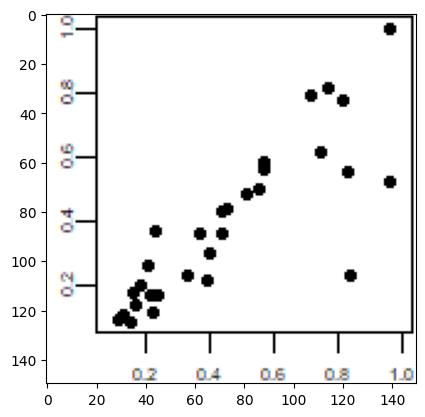

In [16]:
img = mpimg.imread(div + "cwtadyfn.png")
imgplot = plt.imshow(img)
plt.show()

# Process Image with cv2

In [5]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

PATH = "/home/wazenmai/Warehouse/tmp/correlation_assignment/"


In [95]:
def get_data(data, data_type):
    if data_type == "csv":
        df = pd.read_csv(PATH + data)
    else:
        df = data
    print(df.shape)
    # analyze_corr(df)
    names = df["id"].values.tolist()
    labels = df["corr"].values.tolist()
    labels = np.expand_dims(np.array(labels), axis=1)
    data = []
    for id, name in enumerate(names):
        img = cv2.imread(os.path.join(PATH, "images", name + ".png"), cv2.IMREAD_GRAYSCALE)
        img = np.expand_dims(img, axis=0)
        data.append(img)
        if id % 5000 == 0:
            print(id)
    data = np.stack(data)
    return data, labels

def data2loader(data, label, batch_size, shuffle):
    tensor_x = torch.Tensor(data) # transform to torch tensor
    tensor_y = torch.Tensor(label)

    my_dataset = TensorDataset(tensor_x,tensor_y)
    my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)
    return my_dataloader

In [97]:
def split_train_and_valid(csv_name, train_ratio):
    df = pd.read_csv(PATH + csv_name)
    total = df.shape[0]
    df = df.sample(frac=1).reset_index(drop=True) # shuffel data

    train_df = df.iloc[:int(total * train_ratio), :]
    valid_df = df.iloc[int(total * train_ratio):, :]
    
    valid_data, valid_label = get_data(valid_df, "dataframe")
    train_data, train_label = get_data(train_df, "dataframe")
    return train_data, train_label, valid_data, valid_label

train_data, train_label, valid_data, valid_label = split_train_and_valid("train.csv", 0.8)
train_dataloader = data2loader(train_data, train_label, batch_size=32, shuffle=True)
valid_dataloader = data2loader(valid_data, valid_label, batch_size=32, shuffle=False)

(27000, 2)
0
5000
10000
15000
20000
25000
(108000, 2)
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000


In [61]:
data, label = get_data("test.csv", "csv")
print(data.shape, label.shape)
dataloader = data2loader(data, label, batch_size=16, shuffle=True)

(15000, 2)
positive_corr: , 7650, 0.51%
negative_corr: , 7350, 0.49%
zero_corr: , 0, 0.0%
0
5000
10000
(15000, 1, 150, 150) (15000, 1)


In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [50]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 32
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(32),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 32, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 64, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 128, layers[2], stride = 2)
        # self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(10, stride=1)
        self.fc = nn.Linear(128, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        # print("stage 1: ", x.shape)
        x = self.conv1(x)
        x = self.maxpool(x)
        # print("stage 2: ", x.shape)
        x = self.layer0(x)
        # print("stage 3: ", x.shape)
        x = self.layer1(x)
        # print("stage 4: ", x.shape)
        x = self.layer2(x)
        # x = self.layer3(x)
        x = self.avgpool(x)
        # print("stage 5: ", x.shape)
        x = x.view(x.size(0), -1)
        # print("stage 6: ", x.shape)
        x = torch.tanh(self.fc(x))

        return x

In [116]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 3)
        self.conv2 = nn.Conv2d(12, 24, 3)
        self.conv3 = nn.Conv2d(24, 48, 3)
        
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.AvgPool2d(2)
        
        self.fc1 = nn.Linear(48 * 17 * 17, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        # print("stage 1: ", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        
        # print("stage 2: ", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        
        # print("stage 3: ", x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        
        # print("stage 4: ", x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [117]:
# Training setting
def custom_loss(y_pred, y_true):
    diff = torch.abs(y_true - y_pred) / torch.clamp(torch.min(torch.abs(y_true), torch.abs(y_pred)), min=1e-6)
    # loss = 100.0 * torch.mean(diff)
    loss = torch.mean(diff)
    # print(loss)
    # diff = torch.abs(y_true - y_pred)
    # loss = torch.mean(diff)
    # loss = torch.mean(diff ** 2)
    return loss

def evaluate(model):
    eval_loss = 0.0
    for data in valid_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        eval_loss += loss.item()
    print(f"evaluation loss: {eval_loss / len(valid_dataloader):.4f}") 
    return eval_loss / len(valid_dataloader)

    
# model = ResNet(ResidualBlock, [2, 2, 2, 3], num_classes=1)
model = Net()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters())
num_epochs = 5

sum_p = 0
for name, p in model.named_parameters():
    if p.requires_grad:
        sum_p += p.numel()
print(f"Parameters: {sum_p / 1000000} M")

# Train the model
print("Start training...")
train_losses = []
eval_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        running_loss += loss.item()
        
        if i % 500 == 0:    # print every 500 mini-batches
            print(f"outputs: {torch.squeeze(outputs[:2], 1)}, labels: {torch.squeeze(labels[:2], 1)}")
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.4f}')
            running_loss = 0.0
            
            # go evaluation
            eval_loss = evaluate(model)
            eval_losses.append(eval_loss)
            

Parameters: 1.789025 M
Start training...
outputs: tensor([-1.2854, -1.0964], grad_fn=<SqueezeBackward1>), labels: tensor([0.3442, 0.0848])
[1,     1] loss: 0.0034
evaluation loss: 7923.2171
outputs: tensor([0.2008, 0.6145], grad_fn=<SqueezeBackward1>), labels: tensor([0.1905, 0.6279])
[1,   501] loss: 16.7821
evaluation loss: 0.0034
outputs: tensor([ 0.2995, -0.1222], grad_fn=<SqueezeBackward1>), labels: tensor([ 0.2467, -0.0909])
[1,  1001] loss: 0.0023
evaluation loss: 0.0018
outputs: tensor([-0.5642,  0.4097], grad_fn=<SqueezeBackward1>), labels: tensor([-0.5172,  0.3960])
[1,  1501] loss: 0.0017
evaluation loss: 0.0013
outputs: tensor([-0.0726,  0.0505], grad_fn=<SqueezeBackward1>), labels: tensor([-0.0701,  0.0433])
[1,  2001] loss: 0.0015
evaluation loss: 0.0012
outputs: tensor([-0.1353,  0.6253], grad_fn=<SqueezeBackward1>), labels: tensor([-0.1360,  0.5556])
[1,  2501] loss: 0.0013
evaluation loss: 0.0010
outputs: tensor([0.4310, 0.4640], grad_fn=<SqueezeBackward1>), labels: te

[2.4880805968680866, 0.026313139167752256, 0.0038768429325341624, 0.0011149894205370436, 0.001045806504445392]


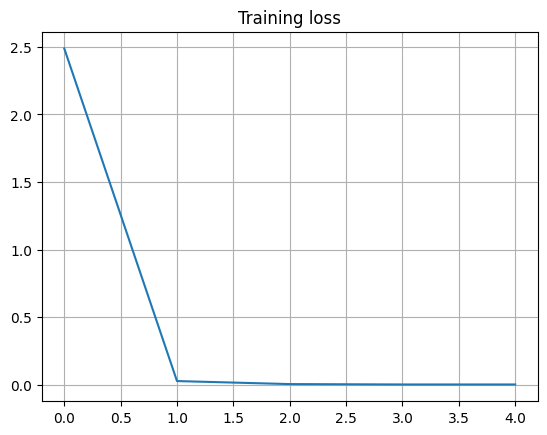

In [124]:
from statistics import mean 
import matplotlib.pyplot as plt

epoch_average_loss = []
sample_per_epoch = len(train_losses) // num_epochs
for i in range(0, len(train_losses), sample_per_epoch):
    epoch_average_loss.append(mean(train_losses[i:i+sample_per_epoch]))
print(epoch_average_loss)

plt.plot(epoch_average_loss)
plt.title("Training loss")
plt.grid()
plt.show()

[1131.8895638164583, 0.001025333633671315, 0.004722153018071466, 0.001190694908548973, 0.0008880899096240501]


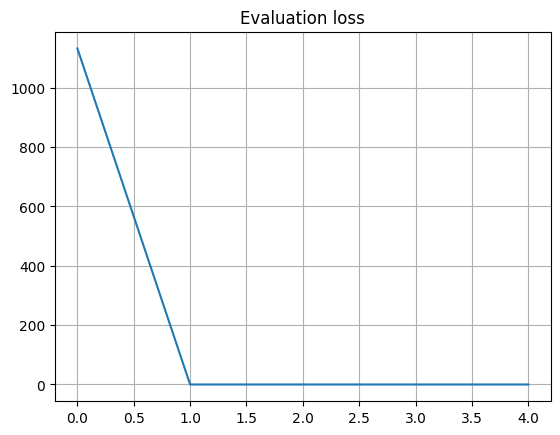

In [126]:
epoch_average_loss = []
sample_per_epoch = 7
for i in range(0, len(eval_losses), sample_per_epoch):
    epoch_average_loss.append(mean(eval_losses[i:i+sample_per_epoch]))
print(epoch_average_loss)

plt.plot(epoch_average_loss)
plt.title("Evaluation loss")
plt.grid()
plt.show()

### Evaluate model on testing set

In [119]:
predictions = []
ground_truth = []
with torch.no_grad():
    for data in dataloader:
        sample_data, sample_label = data
        ground_truth.extend(np.squeeze(sample_label, 1))
        outputs = model(sample_data)
        predictions.extend(np.squeeze(outputs.detach().numpy(), 1))
predictions = np.array(predictions)
ground_truth = np.array(ground_truth)
print(predictions.shape, predictions[:10])
print(ground_truth.shape, ground_truth[:10])

(15000,) [-0.25611228 -0.37173232 -0.5072142   0.6128637  -0.29309013  0.25882882
 -0.02511419  0.481939    0.01907394  0.2653743 ]
(15000,) [-0.2918652  -0.3600063  -0.47188216  0.6127415  -0.30603933  0.27330235
  0.01359741  0.49306127  0.05076659  0.25466463]


In [120]:
y_pred = predictions.tolist()
y_true = ground_truth.tolist()
df = pd.DataFrame(list(zip(y_pred, y_true)),
               columns =['y_pred', 'y_true'])
df

,y_pred,y_true
0,-0.256112,-0.291865
1,-0.371732,-0.360006
2,-0.507214,-0.471882
3,0.612864,0.612741
4,-0.293090,-0.306039
...,...,...
14995,-0.294293,-0.288643
14996,-0.669942,-0.669617
14997,0.299834,0.320755
14998,-0.116604,-0.123295


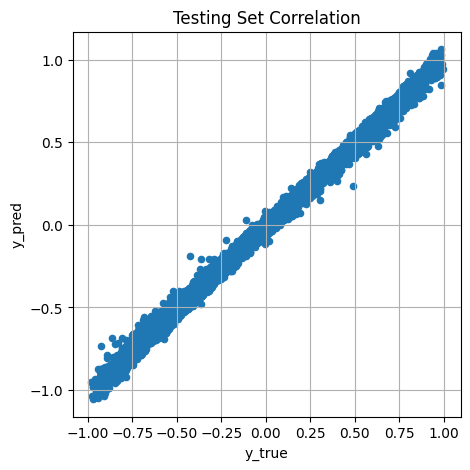

In [127]:
ax1 = df.plot.scatter(x='y_true',y='y_pred', grid=True, figsize=(5, 5), title="Testing Set Correlation")
